In [1]:
import numpy as np

from flagger import PLFlagger, PLNNFlagger
from flagger_tools import PLFlaggerTest
from flagger_tools import get_sampler_model
from matplotlib import pyplot as plt
from tmvbeta import TMVBeta

<string>:11: SyntaxWarning: invalid escape sequence '\s'
<string>:193: SyntaxWarning: invalid escape sequence '\s'


### Synthetic Data

Load model parameters

In [2]:
params = np.load("Data/parameters.npz")
a = params['a']
b = params['b']
cov = params['cov']

Create sampler from model

In [3]:
r = 0.2
P0 = TMVBeta(a[0], b[0], cov[0])
P1 = TMVBeta(a[1], b[1], cov[1])
sampler = get_sampler_model(r, P0, P1)

Administration parameters

In [4]:
K = 20   # Number of reviews per admin
M = 10   # Length of feature vector
N = 100  # Number of test takers per admin
T = 100  # Number of admins (time horizon)

Number of simulated rollouts

In [5]:
rollouts = 20

Simulate PL-LR

In [6]:
lr_opt = 0
rate_lr_opt = np.zeros(T + 1)

for lr in 10 ** np.linspace(-5, 1, 61):
    # Initialize flagger and test
    pl_flagger_lr = PLFlagger(K, M, lr=lr, loss="log_loss")
    test_lr = PLFlaggerTest(pl_flagger_lr, sampler, N, t_warmup=10)

    # Initialize result arrays
    total_lr = np.zeros((rollouts, T + 1))
    detected_lr = np.zeros((rollouts, T + 1))

    # Simulate rollouts
    for n in range(rollouts):
        total_lr[n], detected_lr[n] = test_lr.run(T)

    # Calculate average detection rate
    rate_lr = np.mean(detected_lr[:, 1:] / total_lr[:, 1:], axis=0)

    # Update learning rate if final detection rate exceeds previous best
    if rate_lr[-1] > rate_lr_opt[-1]:
        lr_opt = lr
        rate_lr_opt = rate_lr

print(f"PL-LR: Maximum detection rate = {rate_lr_opt[-1]} at learning rate {lr_opt}")

PL-LR: Maximum detection rate = 0.8272008901507698 at learning rate 0.7943282347242822


Simulate PL-SV

In [7]:
lr_opt = 0
rate_sv_opt = np.zeros(T + 1)

for lr in 10 ** np.linspace(-5, 1, 61):
    # Initialize flagger and test
    pl_flagger_sv = PLFlagger(K, M, lr=lr, loss="hinge")
    test_sv = PLFlaggerTest(pl_flagger_sv, sampler, N, t_warmup=10)

    # Initialize result arrays
    total_sv = np.zeros((rollouts, T + 1))
    detected_sv = np.zeros((rollouts, T + 1))

    # Simulate rollouts
    for n in range(rollouts):
        total_sv[n], detected_sv[n] = test_sv.run(T)

    # Calculate average detection rate
    rate_sv = np.mean(detected_sv[:, 1:] / total_sv[:, 1:], axis=0)

    # Update learning rate if final detection rate exceeds previous best
    if rate_sv[-1] > rate_sv_opt[-1]:
        lr_opt = lr
        rate_sv_opt = rate_sv

print(f"PL-SV: Maximum detection rate = {rate_sv_opt[-1]} at learning rate {lr_opt}")

PL-SV: Maximum detection rate = 0.8278285123826267 at learning rate 0.39810717055349776


Simulate PL-NN

In [8]:
lr_opt = 0
n_hidden_opt = 0
rate_nn_opt = np.zeros(T + 1)

for n_hidden in range(M, 10 * M, int(np.floor(M / 2))):
    for lr in 10 ** np.linspace(-5, 1, 61):
        # Initialize flagger and test
        pl_flagger_nn = PLNNFlagger(K, M, lr=lr, n_hidden=n_hidden)
        test_nn = PLFlaggerTest(pl_flagger_nn, sampler, N, t_warmup=10)
    
        # Initialize result arrays
        total_nn = np.zeros((rollouts, T + 1))
        detected_nn = np.zeros((rollouts, T + 1))
    
        # Simulate rollouts
        for n in range(rollouts):
            total_nn[n], detected_nn[n] = test_nn.run(T)
    
        # Calculate average detection rate
        rate_nn = np.mean(detected_nn[:, 1:] / total_nn[:, 1:], axis=0)
    
        # Update learning rate if final detection rate exceeds previous best
        if rate_nn[-1] > rate_nn_opt[-1]:
            lr_opt = lr
            n_hidden_opt = n_hidden
            rate_nn_opt = rate_nn

print(f"PL-NN: Maximum detection rate = {rate_nn_opt[-1]} at learning rate {lr_opt} and hidden layer width {n_hidden_opt}")

PL-NN: Maximum detection rate = 0.7088195495046529 at learning rate 0.00794328234724282 and hidden layer width 85


Plot average detection rates

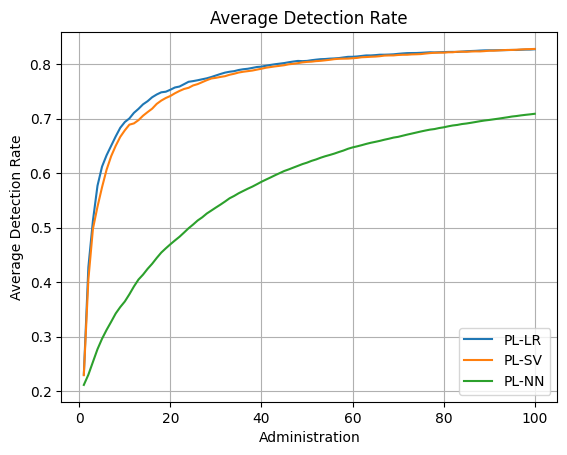

In [9]:
plt.plot(range(1, T+1), rate_lr_opt, label="PL-LR")
plt.plot(range(1, T+1), rate_sv_opt, label="PL-SV")
plt.plot(range(1, T+1), rate_nn_opt, label="PL-NN")
plt.title("Average Detection Rate")
plt.ylabel("Average Detection Rate")
plt.xlabel("Administration")
plt.legend()
plt.grid()